In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tomophantom
from tomophantom import TomoP3D
from tomophantom.supp.qualitymetrics import QualityTools
from tomophantom.supp.flatsgen import synth_flats
import mrcfile

saveFolder = '/home/ubuntu/Thesis/data/S2SDenoising/dummy_tomograms'

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 80

Building 3D phantom using TomoPhantom software


<Figure size 960x640 with 0 Axes>

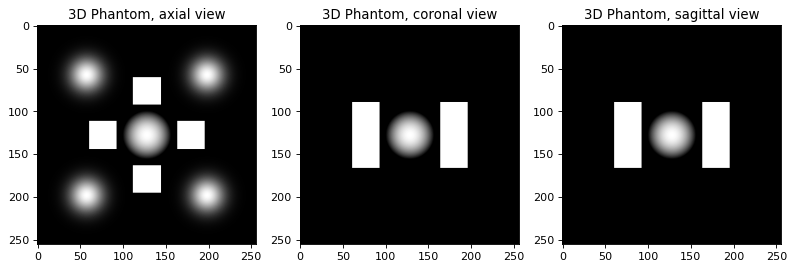

In [3]:
print ("Building 3D phantom using TomoPhantom software")
model = 9 # select a model number from the library: 9, 14, 16
N_size = 256 # Define phantom dimensions using a scalar value (cubic phantom)
path = os.path.dirname(tomophantom.__file__)
path_library3D = os.path.join(path, "Phantom3DLibrary.dat")
#This will generate a N_size x N_size x N_size phantom (3D)
phantom_tm = TomoP3D.Model(model, N_size, path_library3D)

sliceSel = int(0.5*N_size)
plt.gray()
plt.figure() 
plt.subplot(131)
plt.imshow(phantom_tm[sliceSel,:,:],vmin=0, vmax=1)
plt.title('3D Phantom, axial view')

plt.subplot(132)
plt.imshow(phantom_tm[:,sliceSel,:],vmin=0, vmax=1)
plt.title('3D Phantom, coronal view')

plt.subplot(133)
plt.imshow(phantom_tm[:,:,sliceSel],vmin=0, vmax=1)
plt.title('3D Phantom, sagittal view')
plt.show()

filename = 'tomoPhantom_model%i.mrc' %model
with mrcfile.new(os.path.join(saveFolder, filename), overwrite=True) as mrc:
    mrc.set_data(phantom_tm)

In [38]:
# 3D parallel beam projection geometry related parameters:
Horiz_det = int(np.sqrt(2)*N_size) # detector column count (horizontal)
Vert_det = N_size # detector row count (vertical) (no reason for it to be > N)
#### original params #
# angles_num = int(0.5*np.pi*N_size); # angles number original
# angles = np.linspace(0.0,179.9,angles_num,dtype='float32') # in degrees
#### missing wedge
angles_num = int(0.5*np.pi*N_size) # angles number original
angles = list(np.linspace(0,60,angles_num//2,dtype='float32')) # in degrees
_angles = list(np.linspace(120,180,angles_num//2,dtype='float32')) # in degrees
angles = np.array(angles.append(_angles))

angles_rad = angles*(np.pi/180.0)
#%%
print ("Building 3D analytical projection data with TomoPhantom")
projData3D_analyt= TomoP3D.ModelSino(model, N_size, Horiz_det, Vert_det, angles, path_library3D)

intens_max_clean = np.max(projData3D_analyt)
sliceSel = 150
plt.figure() 
plt.subplot(131)
plt.imshow(projData3D_analyt[:,sliceSel,:],vmin=0, vmax=intens_max_clean)
plt.title('2D Projection (analytical)')
plt.subplot(132)
plt.imshow(projData3D_analyt[sliceSel,:,:],vmin=0, vmax=intens_max_clean)
plt.title('Sinogram view')
plt.subplot(133)
plt.imshow(projData3D_analyt[:,:,sliceSel],vmin=0, vmax=intens_max_clean)
plt.title('Tangentogram view')
plt.show()

TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

Adding noise to projection data
Poisson noise has been added to the data.


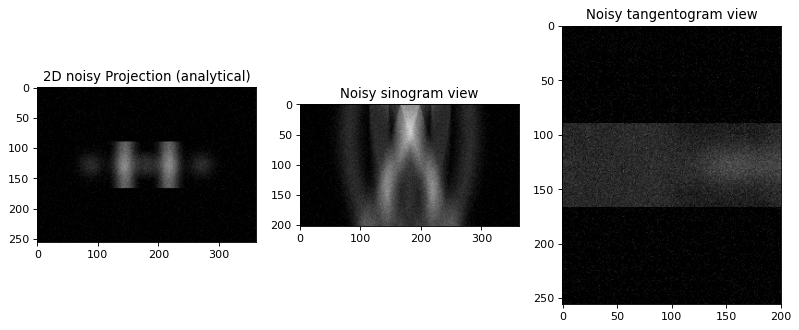

In [36]:
print ("Adding noise to projection data")
from tomophantom.supp.artifacts import _Artifacts_

# forming dictionaries with artifact types
_noiseG_ =  {'noise_type' : 'Gaussian',
            'noise_amplitude' : 5, # variance
            'noise_seed' : 0}

_noiseP_ =  {'noise_type' : 'Poisson',
            'noise_amplitude' : 500, # noise amplitude
            'noise_seed' : 0}

_stripes_ = {'stripes_percentage' : 1.2,
             'stripes_maxthickness' : 3.0,
             'stripes_intensity' : 0.25,
             'stripes_type' : 'mix',
             'stripes_variability' : 0.005}


projData3D_analyt_noisy = _Artifacts_(projData3D_analyt, **_noiseP_)
# projData3D_analyt_noisy = _Artifacts_(projData3D_analyt_noisy, **_noiseG_)

intens_max = np.max(projData3D_analyt_noisy)
sliceSel = int(0.5*N_size)
plt.figure() 
plt.subplot(131)
plt.imshow(projData3D_analyt_noisy[:,sliceSel,:],vmin=0, vmax=intens_max)
plt.title('2D noisy Projection (analytical)')
plt.subplot(132)
plt.imshow(projData3D_analyt_noisy[sliceSel,:,:],vmin=0, vmax=intens_max)
plt.title('Noisy sinogram view')
plt.subplot(133)
plt.imshow(projData3D_analyt_noisy[:,:,sliceSel],vmin=0, vmax=intens_max)
plt.title('Noisy tangentogram view')
plt.show()

Reconstruction using FBP from tomobar


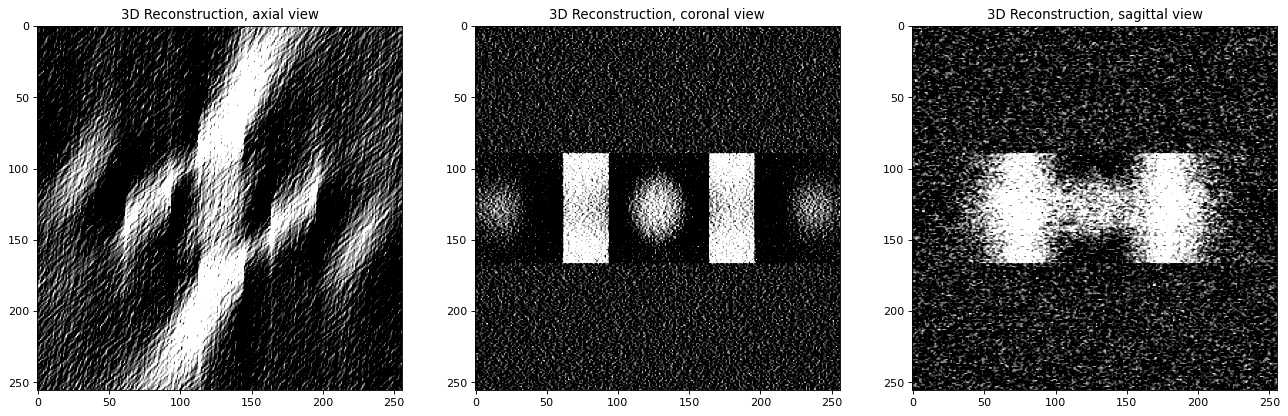

In [37]:
print ("Reconstruction using FBP from tomobar")
# initialise tomobar DIRECT reconstruction class ONCE
from tomobar.methodsDIR import RecToolsDIR
RectoolsDIR = RecToolsDIR(DetectorsDimH = Horiz_det,  # DetectorsDimH # detector dimension (horizontal)
                    DetectorsDimV = Vert_det,  # DetectorsDimV # detector dimension (vertical) for 3D case only
                    CenterRotOffset = None, # The Center of Rotation (CoR) scalar
                    AnglesVec = angles_rad, # array of angles in radians
                    ObjSize = N_size, # a scalar to define reconstructed object dimensions
                    device_projector = 'gpu')

recNumerical= RectoolsDIR.FBP(projData3D_analyt_noisy) # FBP reconstruction

sliceSel = int(0.5*N_size)
max_val = 1
#plt.gray()
plt.figure(figsize=(20, 14)) 
plt.subplot(131)
plt.imshow(recNumerical[sliceSel,:,:],vmin=0, vmax=max_val)
plt.title('3D Reconstruction, axial view')

plt.subplot(132)
plt.imshow(recNumerical[:,sliceSel,:],vmin=0, vmax=max_val)
plt.title('3D Reconstruction, coronal view')

plt.subplot(133)
plt.imshow(recNumerical[:,:,sliceSel],vmin=0, vmax=max_val)
plt.title('3D Reconstruction, sagittal view')
plt.show()


# Generate noisy versions

## Poisson

Adding noise to projection data
Poisson noise has been added to the data.
Reconstruction using FBP from tomobar


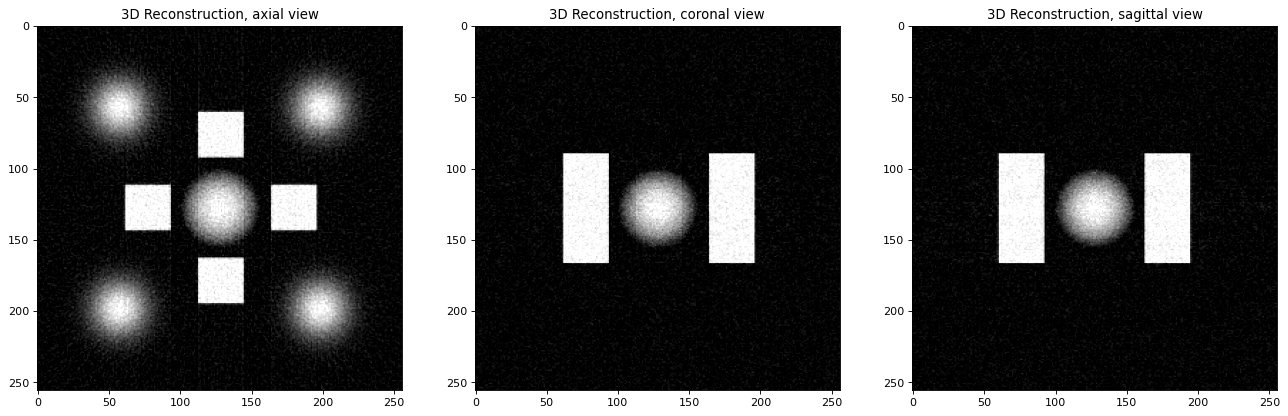

In [10]:
print ("Adding noise to projection data")
from tomophantom.supp.artifacts import _Artifacts_

# forming dictionaries with artifact types
_noiseP_ =  {'noise_type' : 'Poisson',
            'noise_amplitude' : 5000, # noise amplitude
            'noise_seed' : 0}


projData3D_analyt_noisy = _Artifacts_(projData3D_analyt, **_noiseP_)

print ("Reconstruction using FBP from tomobar")
# initialise tomobar DIRECT reconstruction class ONCE
from tomobar.methodsDIR import RecToolsDIR
RectoolsDIR = RecToolsDIR(DetectorsDimH = Horiz_det,  # DetectorsDimH # detector dimension (horizontal)
                    DetectorsDimV = Vert_det,  # DetectorsDimV # detector dimension (vertical) for 3D case only
                    CenterRotOffset = None, # The Center of Rotation (CoR) scalar
                    AnglesVec = angles_rad, # array of angles in radians
                    ObjSize = N_size, # a scalar to define reconstructed object dimensions
                    device_projector = 'gpu')

recNumerical = RectoolsDIR.FBP(projData3D_analyt_noisy) # FBP reconstruction

sliceSel = int(0.5*N_size)
max_val = 1
#plt.gray()
plt.figure(figsize=(20, 14)) 
plt.subplot(131)
plt.imshow(recNumerical[sliceSel,:,:],vmin=0, vmax=max_val)
plt.title('3D Reconstruction, axial view')

plt.subplot(132)
plt.imshow(recNumerical[:,sliceSel,:],vmin=0, vmax=max_val)
plt.title('3D Reconstruction, coronal view')

plt.subplot(133)
plt.imshow(recNumerical[:,:,sliceSel],vmin=0, vmax=max_val)
plt.title('3D Reconstruction, sagittal view')

filename = 'tomoPhantom_model%i_Poisson%i.mrc' %(model, _noiseP_['noise_amplitude'])
with mrcfile.new(os.path.join(saveFolder, filename), overwrite=True) as mrc:
    mrc.set_data(recNumerical)

## Gaussian

Adding noise to projection data
Gaussian noise has been added to the data.
Reconstruction using FBP from tomobar


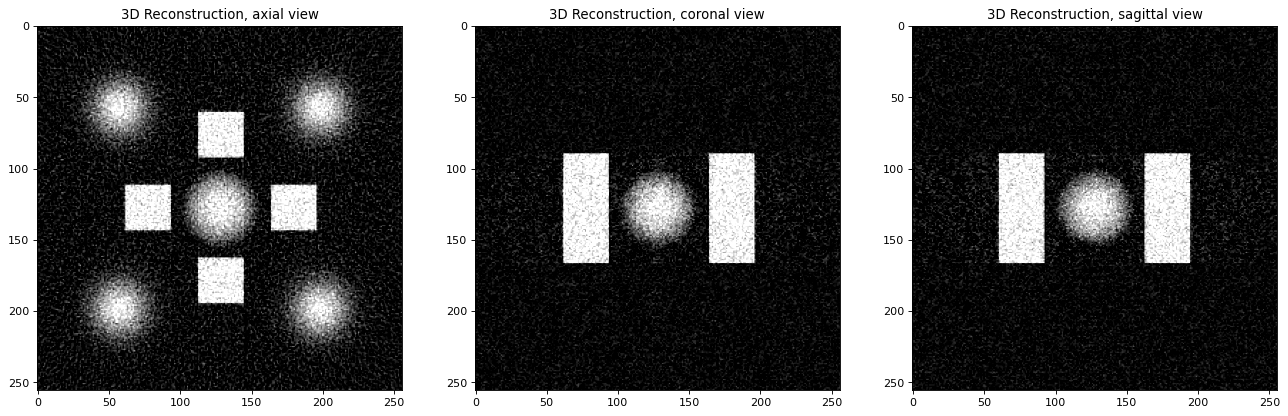

In [11]:
print ("Adding noise to projection data")
from tomophantom.supp.artifacts import _Artifacts_

# forming dictionaries with artifact types
_noiseG_ =  {'noise_type' : 'Gaussian',
            'noise_amplitude' : 5, # noise amplitude
            'noise_seed' : 0}


projData3D_analyt_noisy = _Artifacts_(projData3D_analyt, **_noiseG_)

print ("Reconstruction using FBP from tomobar")
# initialise tomobar DIRECT reconstruction class ONCE
from tomobar.methodsDIR import RecToolsDIR
RectoolsDIR = RecToolsDIR(DetectorsDimH = Horiz_det,  # DetectorsDimH # detector dimension (horizontal)
                    DetectorsDimV = Vert_det,  # DetectorsDimV # detector dimension (vertical) for 3D case only
                    CenterRotOffset = None, # The Center of Rotation (CoR) scalar
                    AnglesVec = angles_rad, # array of angles in radians
                    ObjSize = N_size, # a scalar to define reconstructed object dimensions
                    device_projector = 'gpu')

recNumerical= RectoolsDIR.FBP(projData3D_analyt_noisy) # FBP reconstruction

sliceSel = int(0.5*N_size)
max_val = 1
#plt.gray()
plt.figure(figsize=(20, 14)) 
plt.subplot(131)
plt.imshow(recNumerical[sliceSel,:,:],vmin=0, vmax=max_val)
plt.title('3D Reconstruction, axial view')

plt.subplot(132)
plt.imshow(recNumerical[:,sliceSel,:],vmin=0, vmax=max_val)
plt.title('3D Reconstruction, coronal view')

plt.subplot(133)
plt.imshow(recNumerical[:,:,sliceSel],vmin=0, vmax=max_val)
plt.title('3D Reconstruction, sagittal view')

filename = 'tomoPhantom_model%i_Gauss%i.mrc' %(model, _noiseG_['noise_amplitude'])
with mrcfile.new(os.path.join(saveFolder, filename), overwrite=True) as mrc:
    mrc.set_data(recNumerical)

## Poisson + Gaussian

Adding noise to projection data
Poisson noise has been added to the data.
Gaussian noise has been added to the data.
Reconstruction using FBP from tomobar


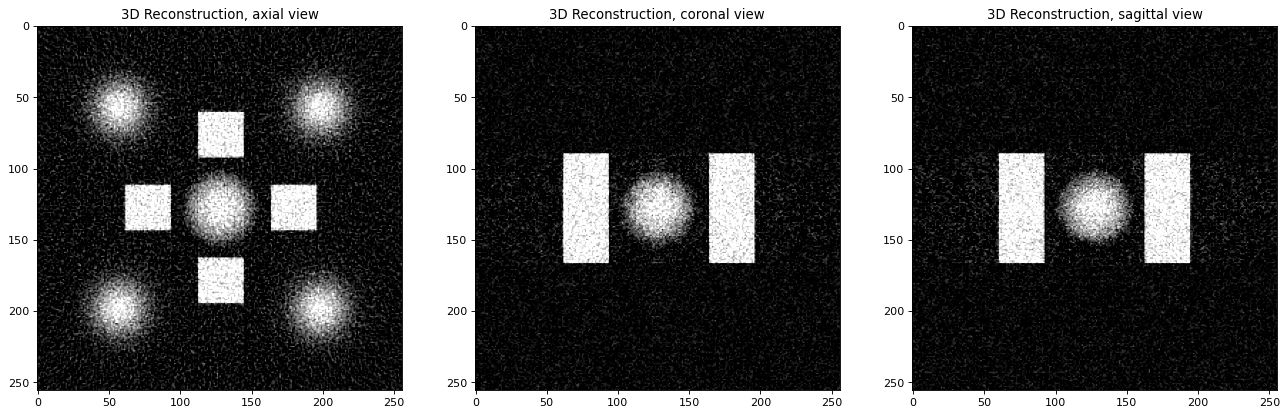

In [12]:
print ("Adding noise to projection data")
from tomophantom.supp.artifacts import _Artifacts_

# forming dictionaries with artifact types
_noiseP_ =  {'noise_type' : 'Poisson',
            'noise_amplitude' : 5, # noise amplitude
            'noise_seed' : 0}

_noiseG_ =  {'noise_type' : 'Gaussian',
            'noise_amplitude' : 5, # noise amplitude
            'noise_seed' : 0}


projData3D_analyt_noisy = _Artifacts_(projData3D_analyt, **_noiseP_)
projData3D_analyt_noisy = _Artifacts_(projData3D_analyt_noisy, **_noiseG_)

print ("Reconstruction using FBP from tomobar")
# initialise tomobar DIRECT reconstruction class ONCE
from tomobar.methodsDIR import RecToolsDIR
RectoolsDIR = RecToolsDIR(DetectorsDimH = Horiz_det,  # DetectorsDimH # detector dimension (horizontal)
                    DetectorsDimV = Vert_det,  # DetectorsDimV # detector dimension (vertical) for 3D case only
                    CenterRotOffset = None, # The Center of Rotation (CoR) scalar
                    AnglesVec = angles_rad, # array of angles in radians
                    ObjSize = N_size, # a scalar to define reconstructed object dimensions
                    device_projector = 'gpu')

recNumerical= RectoolsDIR.FBP(projData3D_analyt_noisy) # FBP reconstruction

sliceSel = int(0.5*N_size)
max_val = 1
#plt.gray()
plt.figure(figsize=(20, 14)) 
plt.subplot(131)
plt.imshow(recNumerical[sliceSel,:,:],vmin=0, vmax=max_val)
plt.title('3D Reconstruction, axial view')

plt.subplot(132)
plt.imshow(recNumerical[:,sliceSel,:],vmin=0, vmax=max_val)
plt.title('3D Reconstruction, coronal view')

plt.subplot(133)
plt.imshow(recNumerical[:,:,sliceSel],vmin=0, vmax=max_val)
plt.title('3D Reconstruction, sagittal view')

filename = 'tomoPhantom_model%i_Poisson%i+Gauss%i.mrc' %(model, _noiseP_['noise_amplitude'], _noiseG_['noise_amplitude'])
with mrcfile.new(os.path.join(saveFolder, filename), overwrite=True) as mrc:
    mrc.set_data(recNumerical)

## Poisson + Gaussian + Stripes

Adding noise to projection data
Poisson noise has been added to the data.
Gaussian noise has been added to the data.
Reconstruction using FBP from tomobar
Stripes leading to ring artefacts have been simulated.


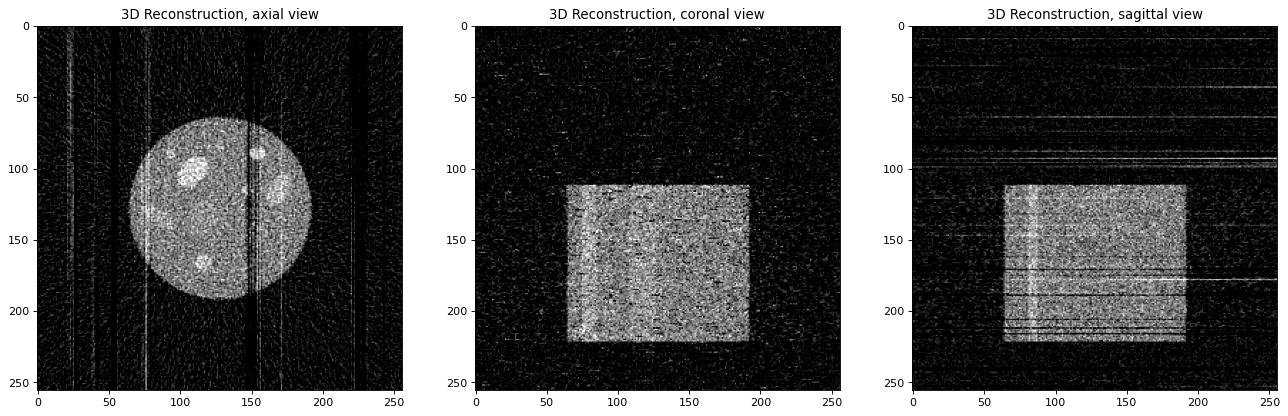

In [13]:
print ("Adding noise to projection data")
from tomophantom.supp.artifacts import _Artifacts_

# forming dictionaries with artifact types
_noiseP_ =  {'noise_type' : 'Poisson',
            'noise_amplitude' : 5000, # noise amplitude
            'noise_seed' : 0}

_noiseG_ =  {'noise_type' : 'Gaussian',
            'noise_amplitude' : 5, # noise amplitude
            'noise_seed' : 0}


projData3D_analyt_noisy = _Artifacts_(projData3D_analyt, **_noiseP_)
projData3D_analyt_noisy = _Artifacts_(projData3D_analyt_noisy, **_noiseG_)

print ("Reconstruction using FBP from tomobar")
# initialise tomobar DIRECT reconstruction class ONCE
from tomobar.methodsDIR import RecToolsDIR
RectoolsDIR = RecToolsDIR(DetectorsDimH = Horiz_det,  # DetectorsDimH # detector dimension (horizontal)
                    DetectorsDimV = Vert_det,  # DetectorsDimV # detector dimension (vertical) for 3D case only
                    CenterRotOffset = None, # The Center of Rotation (CoR) scalar
                    AnglesVec = angles_rad, # array of angles in radians
                    ObjSize = N_size, # a scalar to define reconstructed object dimensions
                    device_projector = 'gpu')

_stripes_ = {'stripes_percentage' : 5,
             'stripes_maxthickness' : 3.0,
             'stripes_intensity' : 0.25,
             'stripes_type' : 'mix',
             'stripes_variability' : 0.01,
             'seed':0}

recNumerical= RectoolsDIR.FBP(projData3D_analyt_noisy) # FBP reconstruction
recNumerical = _Artifacts_(recNumerical, **_stripes_)

sliceSel = int(0.5*N_size)
max_val = 1
#plt.gray()
plt.figure(figsize=(20, 14)) 
plt.subplot(131)
plt.imshow(recNumerical[sliceSel,:,:],vmin=0, vmax=max_val)
plt.title('3D Reconstruction, axial view')

plt.subplot(132)
plt.imshow(recNumerical[:,sliceSel,:],vmin=0, vmax=max_val)
plt.title('3D Reconstruction, coronal view')

plt.subplot(133)
plt.imshow(recNumerical[:,:,sliceSel],vmin=0, vmax=max_val)
plt.title('3D Reconstruction, sagittal view')

filename = 'tomoPhantom_model%i_Poisson%i+Gauss%i+stripes.mrc' %(model, _noiseP_['noise_amplitude'], _noiseG_['noise_amplitude'])
with mrcfile.new(os.path.join(saveFolder, filename), overwrite=True) as mrc:
    mrc.set_data(recNumerical)